# Goal of This Notebook
1. Pull links to the most recent data from the SEC website:
    - https://www.sec.gov/dera/data/financial-statement-data-sets.html
2. Download the zip files from the urls
3. Unzip and format data into "workable" format.
4. Save as CSV and Parquet format.

In [1]:
import pandas as pd
import numpy as np

import requests
import re
import urllib.request

from glob import glob
import shutil
import os

from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 500)

# Step 1 & 2. Download Files and Unzip

In [2]:
def get_links(site = 'https://www.sec.gov/dera/data/financial-statement-data-sets.html'):
    r  = requests.get(site)
    data = r.text
    soup = BeautifulSoup(data)

    links = []
    for link in soup.find_all('a'):
        links.append(link.get('href'))

    zips = [c for c in links if str(c).endswith('.zip')]
    zips = [*set(zips)]
    zips = ['http://www.sec.gov' + a for a in zips]
    return zips

def download_zips(player_zips, zip_dir='./'):
    for z in tqdm(player_zips):
        out = z.split('/')[-1]
        urllib.request.urlretrieve(z, f"{zip_dir}/{out}")

def unzip_files(zip_dir='./', delete_zip=True):
    for fn in glob(f'{zip_dir}/*.zip'):
        out_fn = fn.split('.')[1].replace('/','')
        shutil.unpack_archive(fn, out_fn)
        if delete_zip:
            os.remove(fn)

In [3]:
zips = get_links()

# For now filter down to 2020s
# TODO Get this working for all years in the future
# zips = [z for z in zips if '202' in z]
zips.sort()

download_zips(zips)
unzip_files()

  0%|          | 0/55 [00:00<?, ?it/s]

# Step 3. Read and Format Data

# TODO - What heck even is this data?

- sub.txt (Submissions)
    - The submissions data set contains summary information about an entire EDGAR submission. Some fields were sourced directly from EDGAR submission information, while other columns of data were sourced from the Interactive Data attachments of the submission. Note: EDGAR derived fields represent the most recent EDGAR assignment as of a given filing’s submission date and do not necessarily represent the most current assignments.
- tag.txt (Tags)
    - The TAG data set contains all standard taxonomy tags, not just those appearing in submissions to date, and also includes all custom taxonomy tags defined in the submissions.  The source is the “as filed” XBRL filer submissions.  The standard tags are derived from taxonomies in http://www.sec.gov/info/edgar/edgartaxonomies.shtml. 

- num.txt (Numbers)
    - The NUM data set contains numeric data, one row per data point in the financial statements. The source for the table is the “as filed” XBRL filer submissions.
- pre.txt (Presentation of Statements)
    - The PRE data set contains one row for each line of the financial statements tagged by the filer.  The source for the data set is the “as filed” XBRL filer submissions.   Note that there may be more than one row per entry in NUM because the same tag can appear in more than one statement (the tag NetIncome, for example can appear in both the Income Statement and Cash Flows in a single financial statement, and the tag Cash may appear in both the Balance Sheet and Cash Flows).


In [4]:
!ls 2022q3/ -lh

total 444M
-rw-rw-r-- 1 robmulla robmulla 273M Nov 15 20:41 num.txt
-rw-rw-r-- 1 robmulla robmulla 143M Nov 15 20:41 pre.txt
-rw-rw-r-- 1 robmulla robmulla 149K Nov 15 20:41 readme.htm
-rw-rw-r-- 1 robmulla robmulla 6.5M Nov 15 20:41 sub.txt
-rw-rw-r-- 1 robmulla robmulla  22M Nov 15 20:41 tag.txt


## Read and concat "sub" files

In [5]:
sub_files = glob('*/sub.txt')
subs = []
for f in tqdm(sub_files):
    subs.append(pd.read_csv(f, sep='\t', low_memory=False).assign(filename=f))
subs = pd.concat(subs)
subs.to_parquet('submissions_combined.parquet')

  0%|          | 0/55 [00:00<?, ?it/s]

In [6]:
tag_files = glob('*/tag.txt')
tags = []
for f in tqdm(tag_files):
    tags.append(pd.read_csv(f, sep='\t').assign(filename=f))
tags = pd.concat(tags)
tags.to_parquet('tags_combined.parquet')

  0%|          | 0/55 [00:00<?, ?it/s]

In [7]:
for year in tqdm(range(2009, 2031)):
    num_files = glob(f'*{year}*/num.txt')
    if len(num_files) == 0:
        continue
    nums = []
    for f in num_files:
        nums.append(pd.read_csv(f, sep='\t').assign(filename=f))
    nums = pd.concat(nums)
    nums.to_parquet(f'numbers_combined_{year}.parquet')

  0%|          | 0/22 [00:00<?, ?it/s]

/tmp/ipykernel_2781584/4129995374.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  nums.append(pd.read_csv(f, sep='\t').assign(filename=f))
/tmp/ipykernel_2781584/4129995374.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  nums.append(pd.read_csv(f, sep='\t').assign(filename=f))
/tmp/ipykernel_2781584/4129995374.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  nums.append(pd.read_csv(f, sep='\t').assign(filename=f))


In [8]:
for year in tqdm(range(2009, 2031)):
    pre_files = glob(f'*{year}*/pre.txt')
    if len(pre_files) == 0:
        continue
    pres = []
    for f in pre_files:
        pres.append(pd.read_csv(f, sep='\t').assign(filename=f))
    pres = pd.concat(pres)
    pres.to_parquet(f'presentation_combined_{year}.parquet')

  0%|          | 0/22 [00:00<?, ?it/s]

# EDA
- GOAL:
    - Find Twitter Filings

In [9]:
# Get the twitter filing numbers
subs_twitter = subs.loc[subs['name'].str.lower().str.contains('twitter')]
# Pull only the 10Q filings
adsh_twit = subs_twitter.query('form == "10-Q"')['adsh'].unique().tolist()
nums['ddate'] = pd.to_datetime(nums['ddate'], format='%Y%m%d')

In [10]:
# nums.query("adsh in @adsh_twit")['tag'].unique()

In [11]:
nums.query("adsh in @adsh_twit").sort_values('value', ascending=False)

,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote,filename
896223,0001418091-22-000075,LiabilitiesAndStockholdersEquity,us-gaap/2021,NaN,2021-12-31,0,USD,1.405952e+10,NaN,2022q2/num.txt
666174,0001418091-22-000147,Assets,us-gaap/2022,NaN,2021-12-31,0,USD,1.405952e+10,NaN,2022q3/num.txt
140114,0001418091-22-000075,Assets,us-gaap/2021,NaN,2021-12-31,0,USD,1.405952e+10,NaN,2022q2/num.txt
1456440,0001418091-22-000147,LiabilitiesAndStockholdersEquity,us-gaap/2022,NaN,2021-12-31,0,USD,1.405952e+10,NaN,2022q3/num.txt
1456439,0001418091-22-000147,LiabilitiesAndStockholdersEquity,us-gaap/2022,NaN,2022-06-30,0,USD,1.357929e+10,NaN,2022q3/num.txt
...,...,...,...,...,...,...,...,...,...,...
260174,0001418091-22-000075,CommitmentsAndContingencies,us-gaap/2021,NaN,2022-03-31,0,USD,NaN,NaN,2022q2/num.txt
926696,0001418091-22-000075,LongTermDebt,us-gaap/2021,NaN,2022-03-31,0,USD,NaN,NaN,2022q2/num.txt
781148,0001418091-22-000147,CommitmentsAndContingencies,us-gaap/2022,NaN,2022-06-30,0,USD,NaN,NaN,2022q3/num.txt
781149,0001418091-22-000147,CommitmentsAndContingencies,us-gaap/2022,NaN,2021-12-31,0,USD,NaN,NaN,2022q3/num.txt


In [12]:
nums.groupby('ddate')

<AxesSubplot:title={'center':'Costs and Expenses at Twitter'}, xlabel='ddate'>

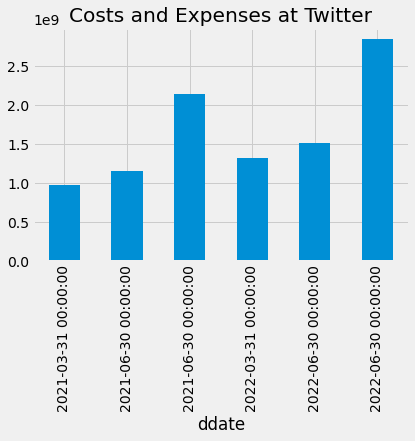

In [13]:
nums.query("adsh in @adsh_twit").query('tag == "CostsAndExpenses"') \
    .set_index('ddate')['value'] \
    .sort_index() \
    .plot(kind='bar',
          title='Costs and Expenses at Twitter')

<AxesSubplot:title={'center':'Assets at Twitter'}, xlabel='ddate'>

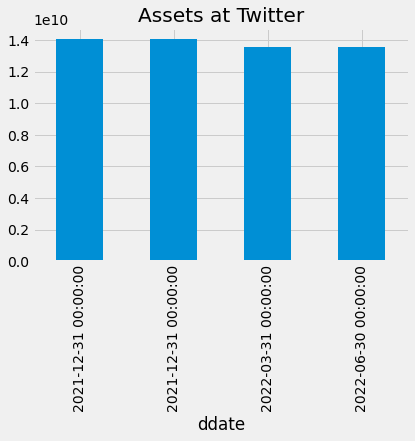

In [14]:
nums.query("adsh in @adsh_twit").query('tag == "Assets"') \
    .set_index('ddate')['value'] \
    .sort_index() \
    .plot(kind='bar',
          title='Assets at Twitter')

## Done